In [1]:
%matplotlib widget
import torch
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/05_ldc.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

# nx_initial = 128
# dx = 1 / nx_initial

# boundary_width = 5
# nx = nx_initial + 2 * boundary_width
# L = 1
# u_mag = 1
# k = 1 * np.pi
# TGV_override = False
# targetRe = 1000

# config['domain']['minExtent'] = [-0.5 - boundary_width * dx,-0.5 - boundary_width * dx]
# config['domain']['maxExtent'] =  [0.5 + boundary_width * dx,0.5 + boundary_width * dx]
# config['domain']['periodic'] = False

# config['boundary']['active'] = True

# config['particle'] = {'nx' : nx}
# config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda', 'checkNaN': True}
# config['compute'] = {'device': 'cpu', 'checkNaN': True}


config = parseDefaultParameters(config)
config = parseModuleParameters(config)
# setViscosityParameters(config, targetRe, L, u_mag)
config['diffusion']['alpha'] = 0.01
# config['diffusion']['pi-switch']=False
# config['gravity']['active'] = False
# config['EOS']['type'] = 'stiffTait'

# print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


In [3]:
# config['boundaryDiffusion']

In [4]:
# from diffSPH.v2.sampling import sampleNoisyParticles
# from diffSPH.v2.modules.divergence import computeDivergence
# from diffSPH.v2.plotting import plotSDF
# from diffSPH.v2.sdf import getSDF, operatorDict

# ngrid = 255
# x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
# y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
# X, Y = torch.meshgrid(x, y, indexing = 'ij')
# P = torch.stack([X,Y], dim=-1)
# points = P.reshape(-1,2)

# sphere_a = lambda points: getSDF('polygon')['function'](points, torch.tensor([[0.5,0.5],[0.5,-0.5],[-0.5,-0.5],[-0.5,0.5]]))
# sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
# inner = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
# outer = lambda points: getSDF('box')['function'](points, torch.tensor([1 + config['particle']['dx'] * config['boundary']['boundary_width'],1 + config['particle']['dx'] * config['boundary']['boundary_width']]).to(points.device))


# translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
# rotated = operatorDict['rotate'](translated, 0.5)

# outer = operatorDict['invert'](outer)
# sdf = operatorDict['union'](inner, outer)
# sdf = operatorDict['invert'](inner)

# # circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# # circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# # sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# # sdf = operatorDict['twist'](sdf, 0.5)
# # sdf = operatorDict['shell'](sdf, 0.125)
# sdf = sdf
# plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [5]:
from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour
from diffSPH.v2.plotUtil import plotRegionswSDF

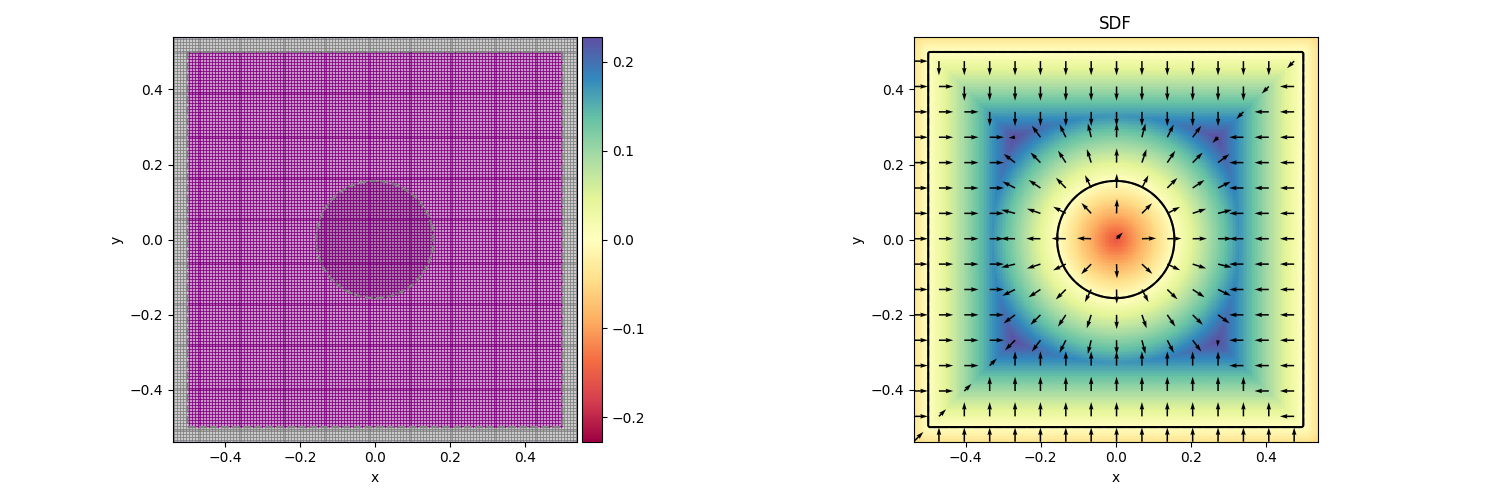

In [6]:


ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([0.5,0.5]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([0.5 + config['particle']['dx'] * config['boundary']['boundary_width'],0.5 + config['particle']['dx'] * config['boundary']['boundary_width']]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](inner)

l = config['particle']['dx'] * 20

inner = lambda points: getSDF('box')['function'](points, torch.tensor([0.15,0.15]).to(points.device))
boundary_sdf2 = inner# operatorDict['invert'](inner)

boundary_sdf2 = lambda points: getSDF('circle')['function'](points, torch.tensor(l).to(points.device))


fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([0.5,0.5]).to(points.device))
# fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    {
        'sdf': boundary_sdf,
        'type': 'boundary',
        'velocity': torch.tensor([0.,0.]),
        'kind': 'zero',
        'particles': sampleParticles(config, sdfs = [boundary_sdf])[0],
        'contour': find_contour(boundary_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },
    {
        'sdf': boundary_sdf2,
        'type': 'boundary',
        'kind': 'free-slip',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [boundary_sdf2])[0],
        'contour': find_contour(boundary_sdf2(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },
    {
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions

plotRegionswSDF(config)

In [7]:
# from diffSPH.v2.sampling import *

In [8]:

# particleState['supports'] - config['particle']['support']

In [9]:
config['particle']

{'nx': 138,
 'dx': tensor(0.0078, device='cuda:0'),
 'support': tensor(0.0296, device='cuda:0'),
 'defaultVolume': tensor(6.1035e-05, device='cuda:0'),
 'defaultSupport': tensor(0.0296, device='cuda:0'),
 'volume': tensor(6.1035e-05, device='cuda:0'),
 'smoothingLength': tensor(0.0156, device='cuda:0')}

In [10]:
len(regions)

3

state[fluid                   ]: dict
state[fluid                   ][numParticles      ]: 15120	[<class 'int'>]
state[fluid                   ][positions         ]: min: -4.963e-01, max: +4.963e-01, median: -3.673e-03 [torch.Size([15120, 2])	@ cuda:0	x torch.float32	]
state[fluid                   ][areas             ]: min: +6.104e-05, max: +6.104e-05, median: +6.104e-05 [torch.Size([15120])	@ cuda:0	x torch.float32	]
state[fluid                   ][pressures         ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([15120])	@ cuda:0	x torch.float32	]
state[fluid                   ][divergence        ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([15120])	@ cuda:0	x torch.float32	]
state[fluid                   ][masses            ]: min: +6.104e-02, max: +6.104e-02, median: +6.104e-02 [torch.Size([15120])	@ cuda:0	x torch.float32	]
state[fluid                   ][supports          ]: min: +2.965e-02, max: +2.965e-02, median: +2.965e-02 [torch.S

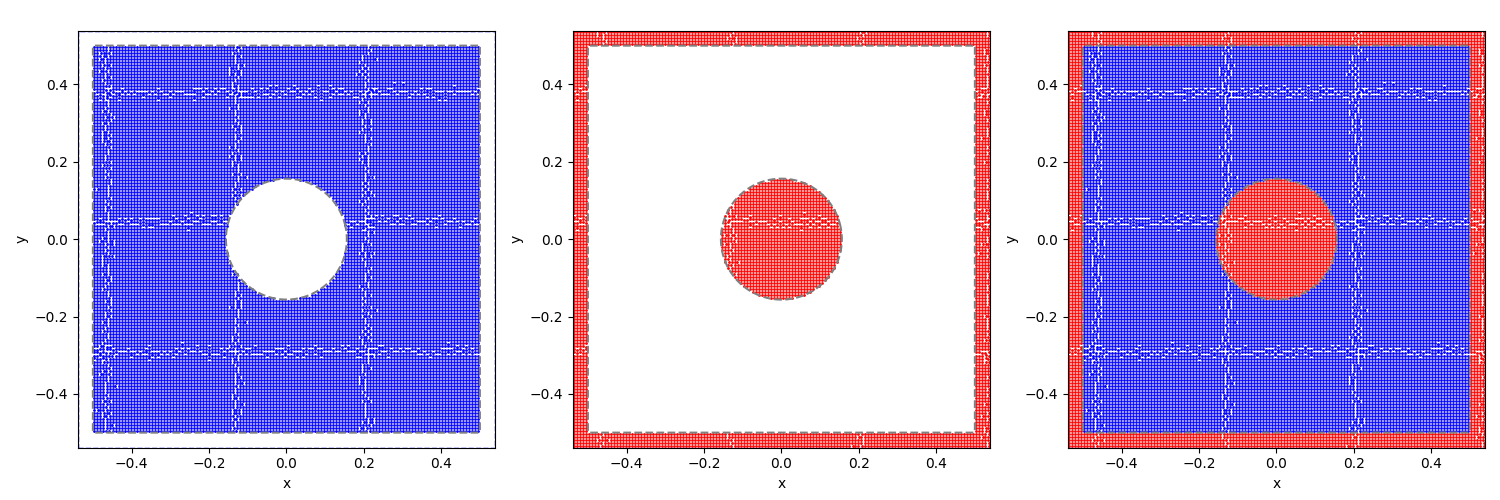

In [11]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs, sampleNoisyParticles
from diffSPH.v2.finiteDifference import centralDifferenceStencil, continuousGradient
from diffSPH.v2.plotUtil import plotInitialParticleSampling
from diffSPH.v2.modules.neighborhood import searchNeighbors


particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'fluid'], filter = True)
# print(particleState)

# particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = regions)
# print(particleState)
boundaryState = processBoundarySDFs(particleState, config, [region['sdf'] for region in regions if region['type'] == 'boundary'], 'regular')


# config['timestep']['dt'] = 5e-4
s = 2
perennialState = {
    'fluid': copy.deepcopy(particleState),
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
    'uidCounter': particleState['numParticles']
}

u = 1

perennialState['fluid']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['fluid']['numParticles'], 2], device = perennialState['fluid']['positions'].device)
perennialState['boundary']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['boundary']['numParticles'], 2], device = perennialState['boundary']['positions'].device)

searchNeighbors(perennialState, config)

printState(perennialState)

plotInitialParticleSampling(perennialState, config)

# p = perennialState['boundary']['positions']
# # inner()
# sdf = inner
# h = config['particle']['support']

# stencil = centralDifferenceStencil(1, 2)
# stencil = stencil.to(p.device)
# sdfValues = sdf(p.cpu()).to(p.device)

# sdfGradient = continuousGradient(sdf, p, stencil, 0.2 * h, 1)
# perennialState['boundary']['normals'] = -sdfGradient / (torch.linalg.norm(sdfGradient, dim = 1, keepdim = True) + 1e-6)
# perennialState['boundary']['distances'] = sdfValues

In [12]:
138**2

19044

In [13]:

# display(fig)

In [14]:
from diffSPH.v2.plotting import visualizeParticleQuantity

In [15]:
# def rampDivergenceFree(positions, noise, sdf_func, offset, d0 = 0.25):
#     sdf = sdf_func(positions)
# #     r = sdf / d0 /2  + 0.5
#     r = (sdf - offset) / d0 / 0.5 - 1
# #     ramped = r * r * (3 - 2 * r)
#     ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
# #     ramped = r
#     ramped[r >= 1] = 1
#     ramped[r <= -1] = -1
# #     ramped[r <= 0] = 0
# #     ramped[r <= -1] = -1
    
#     return (ramped /2 + 0.5) * (noise)

In [16]:
# fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))

In [17]:
# _, boundaryNeighborhood = neighborSearch(perennialState['fluid'], perennialState['boundary'], config)

In [18]:
# divergence = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', neighborhood = perennialState['fluid']['neighborhood'])

# divergence += sphOperationStates(perennialState['fluid'], perennialState['boundary'], (perennialState['fluid']['velocities'], perennialState['boundary']['velocities']), operation = 'divergence', neighborhood = boundaryNeighborhood)
# divergence.shape

In [19]:
# print(perennialState['fluid']['potential'].shape)

# potential = perennialState['fluid']['potential']

In [20]:
# def rampDivergenceFree(positions, noise, sdf_func, offset, d0 = 0.25):
#     sdf = sdf_func(positions)
# #     r = sdf / d0 /2  + 0.5
#     r = (sdf - offset)/ d0
#     r = torch.clamp(r, -1, 1)
#     # return r

#     # r = (sdf - offset) / d0 / 0.5 - 1


#     # return -r
# #     ramped = r * r * (3 - 2 * r)
#     ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
# #     ramped = r
#     ramped[r >= 1] = 1
#     ramped[r <= -1] = -1
# #     ramped[r <= 0] = 0
# #     ramped[r <= -1] = -1
#     return ramped    
#     # return (ramped /2 + 0.5) * (noise)

In [21]:
from diffSPH.v2.sampling import generateRamp, sampleVelocityField

# print(ramp.min() - config['particle']['dx']/2 / config['particle']['support'])
# print(ramp.shape)
# print(potential.shape)

In [22]:
# config['particle']['support']**2 * np.pi / (config['particle']['dx']**2)
# print(config['particle']) 
# searchNeighbors(perennialState, config)

# print(perennialState.keys())
# printState(perennialState['boundary'])

In [23]:
config['compute']

{'device': 'cuda',
 'checkNaN': True,
 'precision': 'float32',
 'dtype': torch.float32}

In [24]:
# filteredState['fluid']['potential'].shape
# print(filteredState['fluid']['potential'].shape)
# print(filteredState['fluid']['masses'].shape)
# print(filteredState['fluid']['numParticles'])

In [25]:

from diffSPH.v2.modules.neighborhood import searchNeighbors
from diffSPH.v2.sampling import generateRamp, getNoiseSampler
ramp = generateRamp(perennialState['fluid'], regions, config)


x = perennialState['fluid']['positions']
noiseSampler = getNoiseSampler(config)
potential = noiseSampler(perennialState['fluid']['positions'])
potential = torch.cos(np.pi * 2 * perennialState['fluid']['positions'][:,0]) * torch.cos(np.pi * 2 * perennialState['fluid']['positions'][:,1]) / 6
ramped = potential * ramp



filteredState = copy.deepcopy(perennialState)
filteredState['fluid']['potential'] = ramped

velocity, divergence = sampleVelocityField(filteredState['fluid'], filteredState['fluid']['neighborhood']
                                           )
u_max = torch.linalg.norm(velocity, dim = 1).max() + 1e-6
u_factor = config['fluid']['u_mag'] / u_max
velocity = velocity * u_factor
perennialState['fluid']['velocities'] = velocity


# divergence = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (velocity, velocity), operation = 'divergence', neighborhood = perennialState['fluid']['neighborhood'])

# # divergence += sphOperationStates(perennialState['fluid'], perennialState['boundary'], (velocity, perennialState['boundary']['velocities']), operation = 'divergence', neighborhood = perennialState['boundaryToFluidNeighborhood'])


# # velocity[:,0] = 
# u_mag = config['fluid']['u_mag']

# # velocity[:,1] =  u_mag * torch.cos(2 * np.pi * particleState['positions'][:,0]) * torch.sin(2 * np.pi * particleState['positions'][:,1])
# # velocity[:,0] = -u_mag * torch.sin(2 * np.pi * particleState['positions'][:,0]) * torch.cos(2 * np.pi * particleState['positions'][:,1])



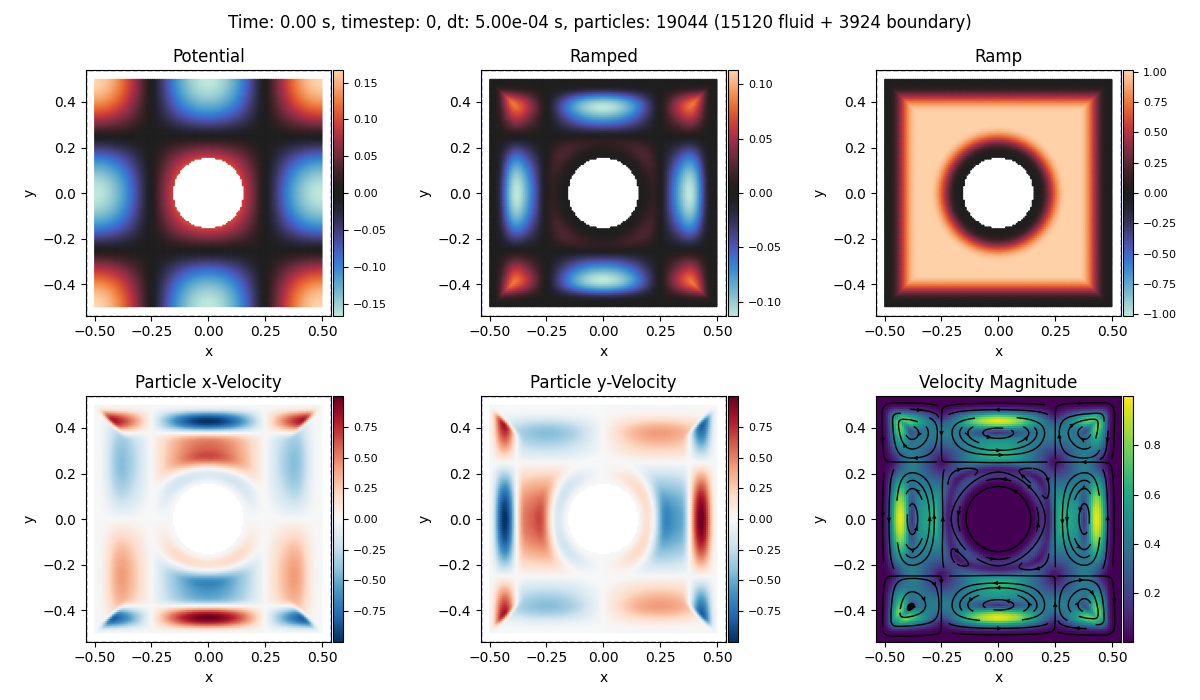

In [26]:
from diffSPH.v2.plotUtil import plotPotentialField
plotPotentialField(perennialState, config, potential, ramped, s = 1)

In [27]:
# boundary_sdfs = [region['sdf'] for region in regions if region['type'] == 'boundary']

# combined_sdf = boundary_sdfs[0]
# for sdf in boundary_sdfs[1:]:
#     combined_sdf = operatorDict['union'](combined_sdf, sdf)

# _, _, sdfValues, sdfGradients = filterParticlesWithSDF(perennialState['boundary']['positions'], operatorDict['invert'](combined_sdf), config['particle']['support'], 1e-4)

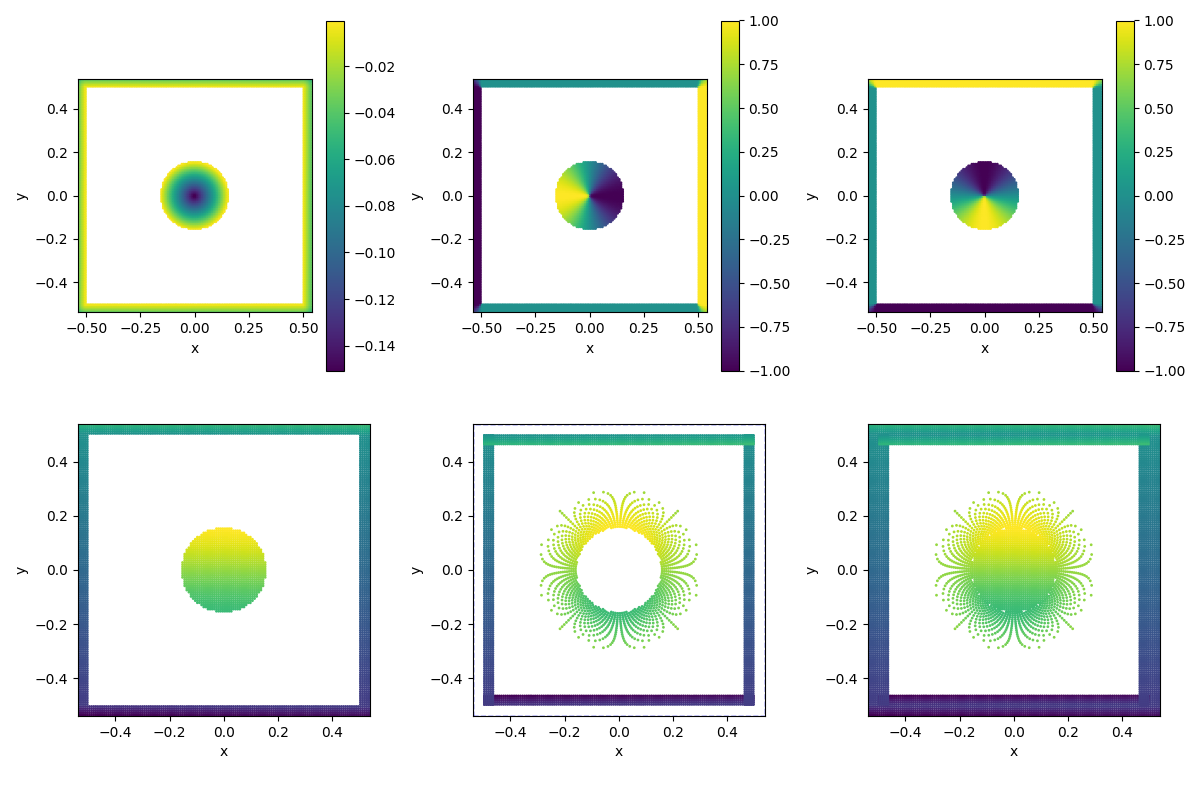

In [28]:
from diffSPH.v2.plotUtil import plotBoundaryParticleswGhosts
plotBoundaryParticleswGhosts(perennialState, config)

In [29]:
# perennialState['fluid']['velocities'] = velocity.clone()

from diffSPH.v2.modules.mDBC import mDBCDensity
from diffSPH.v2.modules.boundaryViscosity import computeBoundaryVelocities

In [30]:
# perennialState['boundary']['bodyIDs']
# boundaryRegions = [region for region in config['regions'] if region['type'] == 'boundary']
# print(boundaryRegions)

In [31]:
for region in config['regions']:
    if region['type'] == 'boundary':
        region['kind'] = 'free-slip'
        # region['kind'] = 'zero'
        # region['kind'] = 'linear'

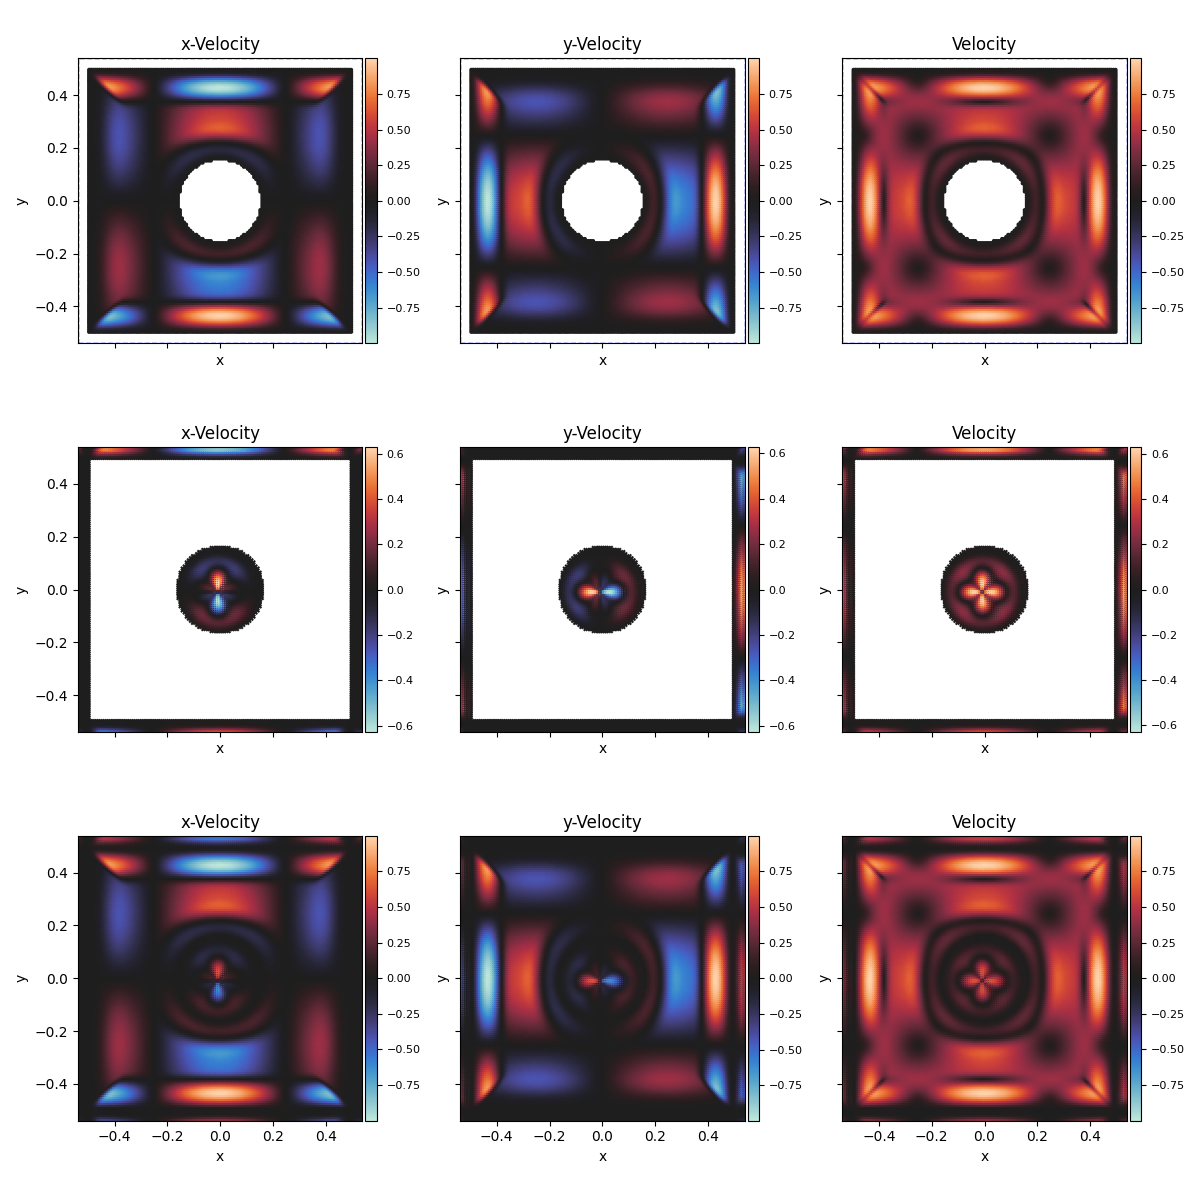

In [32]:
from diffSPH.v2.plotUtil import plotBoundaryVelocityFields
plotBoundaryVelocityFields(perennialState, config)

In [33]:

# print(Ek_0.sum(), Ek.sum())
# print(Ek_0.sum() - Ek.sum())

In [34]:
# jitter = torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['fluid']['numParticles'], 2], device = perennialState['fluid']['positions'].device)

# newState = copy.deepcopy(perennialState)
# newState['fluid']['positions'] += jitter

In [35]:

# from diffSPH.v2.modules.neighborhood import neighborSearch, searchNeighbors
# with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
#     searchNeighbors(newState, config)

In [36]:
# dx, _ = solveShifting(newState, config)
# dx = dx * 100

In [37]:
# fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

# visualizationState = prepVisualizationState(perennialState, config, grid = True)
# # plotRegions(regions, axis[0,0])
# # plotRegions(regions, axis[0,1])

# s = 0.25

# indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
#                                       dx[:,0] / (torch.linalg.norm(dx, dim = -1) + 1e-7),
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0)
# quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
#                                       dx[:,1] / (torch.linalg.norm(dx, dim = -1) + 1e-7),
#                                       mapping = '.y', s = s, 
#                           scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

# l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
#                                       dx,
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Pressure Field', plotBoth = False, which = 'fluid', midPoint = 0)



# fig.tight_layout()

In [38]:
# fi, bj = newState['boundaryToFluidNeighborhood']['indices']

In [39]:
# dx_fi = dx[fi]
# n_bj = perennialState['boundary']['normals'][bj]

In [40]:
# print(dx_fi)
# print(n_bj)

# dx_parallel_to_bdy = dx_fi - torch.sum(dx_fi * n_bj, dim = -1, keepdim = True) * n_bj
# dx_orthogonal_to_bdy = torch.sum(dx_fi * n_bj, dim = -1, keepdim = True) * n_bj

# print(dx_parallel_to_bdy)
# print(dx_orthogonal_to_bdy)

In [41]:
# from diffSPH.v2.compiler import compileSourceFiles

# proj_cpp = compileSourceFiles(
#     ['./cppSrc/vectorProjection.cpp', './cppSrc/vectorProjection.cu'], module_name = 'vectorProjection', verbose = False, openMP = True, verboseCuda = False, cuda_arch = None)
# # from torch.utils.cpp_extension import load

# # sphOperation_cpp = load(name='sphOperations', sources=['/home/winchenbach/dev/diffSPH/partiBench/cppOp.cpp'], verbose = True, with_cuda = False, is_python_module = False, extra_cflags = ['-fopenmp'], extra_ldflags = ['-fopenmp'])
# project_cpp = proj_cpp.projectVectors

In [42]:
# vectors_cpu = dx.cpu()
# normals_cpu = newState['boundary']['normals'].cpu()
# numBoundaryParticles = newState['boundary']['numParticles']
# numFluidParticles = newState['fluid']['numParticles']

# indices = newState['boundaryToFluidNeighborhood']['indices']
# indices = (indices[0].cpu(), indices[1].cpu())
# numNeighbors = newState['boundaryToFluidNeighborhood']['numNeighbors'].cpu()
# neighborOffsets = newState['boundaryToFluidNeighborhood']['neighborOffsets'].cpu()

# projected = project_cpp(vectors_cpu, normals_cpu, numBoundaryParticles, numFluidParticles, indices, numNeighbors, neighborOffsets)

# print(projected, projected.shape)

In [43]:
# vectors_cpu = dx
# normals_cpu = newState['boundary']['normals']
# numBoundaryParticles = newState['boundary']['numParticles']
# numFluidParticles = newState['fluid']['numParticles']

# indices = newState['boundaryToFluidNeighborhood']['indices']
# indices = (indices[0], indices[1])
# numNeighbors = newState['boundaryToFluidNeighborhood']['numNeighbors']
# neighborOffsets = newState['boundaryToFluidNeighborhood']['neighborOffsets']
# projected = project_cpp(vectors_cpu, normals_cpu, numBoundaryParticles, numFluidParticles, indices, numNeighbors, neighborOffsets)


In [44]:
# print(vectors_cpu)
# print(normals_cpu)
# print(numBoundaryParticles)
# print(numFluidParticles)
# print(indices)
# print(numNeighbors)
# print(neighborOffsets)

In [45]:

# projected = project_cpp(vectors_cpu, normals_cpu, numBoundaryParticles, numFluidParticles, indices, numNeighbors, neighborOffsets)



In [46]:
initialState = copy.deepcopy(perennialState)

In [47]:
perennialState = copy.deepcopy(initialState)

# perennialState['fluid']['velocities'][:,0] = 0
# perennialState['fluid']['velocities'][:,1] = 0



# perennialState['boundary']['velocities'][perennialState['boundary']['positions'][:,1] > 0.5 - 1e-4,0] = 1
# perennialState['boundary']['velocities'][perennialState['boundary']['positions'][:,0] > 0.5 - 1e-4,0] = 0
# perennialState['boundary']['velocities'][perennialState['boundary']['positions'][:,0] < -0.5 - 1e-4,0] = 0

# perennialState['fluid']['positions'] += torch.randn_like(perennialState['fluid']['positions']) * 0.05 * config['particle']['dx']

In [48]:
# fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

# visualizationState = prepVisualizationState(perennialState, config, grid = True)
# # plotRegions(regions, axis[0,0])
# # plotRegions(regions, axis[0,1])

# s = 0.25

# indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
#                                       'velocities',
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=False, cmap = 'RdBu_r', title = 'x-Velocity', which = 'both', plotBoth = True, midPoint = 0)
# quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = '.y', s = s, 
#                           scaling = 'sym', gridVisualization=False, cmap = 'RdBu_r', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = True, which = 'both', midPoint = 0)

# l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Pressure Field', plotBoth = True, which = 'both', midPoint = 0)



# fig.tight_layout()

In [49]:
# # perennialState['fluid']['densities'] = perennialState['fluid']['positions'][:,0]* perennialState['fluid']['positions'][:,1]* 1000 + 2000
# perennialState['boundaryGhost'] = buildBoundaryGhostParticles(perennialState, config)
# perennialState['boundary']['densities'], perennialState['boundaryGhost']['densities'] = mDBCDensity(perennialState, config)
# # perennialState['fluid']['densities'] = torch.ones_like(perennialState['fluid']['densities']) * 1000
# print(perennialState['boundary']['densities'][perennialState['boundary']['densities']!=1000])

# torch.any(perennialState['boundary']['positions'].isinf())

In [50]:
from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep, callModule
from diffSPH.v2.modules.density import computeDensity

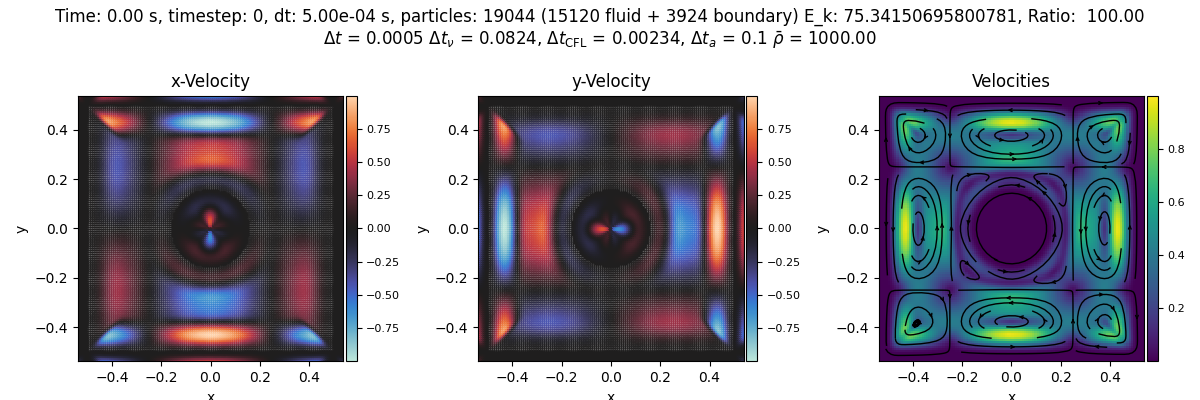

In [51]:
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.5

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'x-Velocity', which = 'both', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocities',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'both', midPoint = 0)

# searchNeighbors(perennialState, config)
# rho, _ = callModule(perennialState, computeDensity, config)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'velocities',
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = True, operation = None, title = 'Velocities', plotBoth = True, which = 'fluid', midPoint = 1000)



fig.tight_layout()

Ek_0 = 0.5 * perennialState['fluid']['masses'] * torch.sum(velocity**2, dim = 1)
Ek = 0.5 * perennialState['fluid']['masses'] * torch.sum(perennialState['fluid']['velocities']**2, dim = 1)

nu = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
nu = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu
dt_v = 0.125 * config['particle']['support']**2 / nu / config['kernel']['kernelScale']**2
# acoustic timestep condition

dt_c = config['timestep']['CFL'] * config['particle']['support'] / config['fluid']['cs'] / config['kernel']['kernelScale']    
# print(dt_v, dt_c)

# acceleration timestep condition
if 'dudt' in perennialState['fluid']: 
    dudt = perennialState['fluid']['dudt']
    max_accel = torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))
    dt_a = 0.25 * torch.sqrt(config['particle']['support'] / (max_accel + 1e-7)) / config['kernel']['kernelScale']
else:
    dt_a = torch.tensor(config['timestep']['maxDt'], dtype = dt_v.dtype, device = dt_v.device)


fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}\n$\\Delta t$ = {perennialState["dt"]} $\\Delta t_\\nu$ = {dt_v:.3g}, $\\Delta t_\\text{{CFL}}$ = {dt_c:.3g}, $\\Delta t_a$ = {dt_a:.3g} $\\bar\\rho$ = {perennialState["fluid"]["densities"].mean():.2f}')

fig.tight_layout()

In [52]:
config['integration']['scheme'] = 'symplecticEuler'

In [53]:
# dx, _ = solveShifting(perennialState, config)
# perennialState['fluid']['shiftAmount'] = dx

# # dx[torch.unique(perennialState['boundaryToFluidNeighborhood']['indices'][0]),:] = 0
# # vectors_cpu = dx
# # normals_cpu = perennialState['boundary']['normals']
# # numBoundaryParticles = perennialState['boundary']['numParticles']
# # numFluidParticles = perennialState['fluid']['numParticles']

# # indices = perennialState['boundaryToFluidNeighborhood']['indices']
# # indices = (indices[0], indices[1])
# # numNeighbors = perennialState['boundaryToFluidNeighborhood']['numNeighbors']
# # neighborOffsets = perennialState['boundaryToFluidNeighborhood']['neighborOffsets']
# # dx = project_cpp(vectors_cpu, normals_cpu, numBoundaryParticles, numFluidParticles, indices, numNeighbors, neighborOffsets)


# ghostState = {
#     'positions': perennialState['fluid']['positions'] + dx,
#     'masses': perennialState['fluid']['masses'],
#     'densities': perennialState['fluid']['densities'],
#     'areas': perennialState['fluid']['areas'],
#     'numParticles': perennialState['fluid']['numParticles'],
#     'supports': perennialState['fluid']['supports'],
# }
# numParticles = perennialState['fluid']['numParticles']
# fluidState = perennialState['fluid']
# boundaryParticleState = perennialState['boundary'] if 'boundary' in perennialState else None

# mergedPositions = torch.cat((fluidState['positions'], boundaryParticleState['positions']), dim = 0) if boundaryParticleState is not None else fluidState['positions']
# mergedVelocities = torch.cat((fluidState['velocities'], boundaryParticleState['velocities']), dim = 0) if boundaryParticleState is not None else fluidState['velocities']
# mergedMasses = torch.cat((fluidState['masses'], boundaryParticleState['masses']), dim = 0) if boundaryParticleState is not None else fluidState['masses']
# mergedAreas = torch.cat((fluidState['areas'], boundaryParticleState['areas']), dim = 0) if boundaryParticleState is not None else fluidState['areas']
# mergedDensities = torch.cat((fluidState['densities'], boundaryParticleState['densities']), dim = 0) if boundaryParticleState is not None else fluidState['densities']
# mergedSupports = torch.cat((fluidState['supports'], boundaryParticleState['supports']), dim = 0) if boundaryParticleState is not None else fluidState['supports']
# boundaryMarker = torch.cat((torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32), torch.ones(boundaryParticleState['positions'].shape[0], dtype = torch.int32))) if boundaryParticleState is not None else torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32)

# mergedState = {
#     'positions': mergedPositions,
#     'velocities': mergedVelocities,
#     'masses': mergedMasses,
#     'densities': mergedDensities,
#     'supports': mergedSupports,
#     'areas': mergedAreas,
#     'numParticles': mergedPositions.shape[0],
#     'boundaryMarker': boundaryMarker
# }

# _, ghostState['neighborhood'] = neighborSearch(ghostState, mergedState, config, True, None, None, False)


# # display(ghostState['neighborhood'])

# xij = -ghostState['neighborhood']['distances'].view(-1,1) * ghostState['neighborhood']['vectors']

# ones_ij = torch.ones_like(xij[:,0])
# dx_ij = xij[:,0]
# dy_ij = xij[:,1]
# dxdy_ij = dx_ij * dy_ij
# dx2_ij = dx_ij**2
# dy2_ij = dy_ij**2

# phi_ij = torch.stack([ones_ij, dx_ij, dy_ij, dxdy_ij, dx2_ij, dy2_ij], dim = 1)
# cross = torch.einsum('nu, nv -> nuv', phi_ij, phi_ij)

# q_j = mergedState['densities'][ghostState['neighborhood']['indices'][1]] 
# M = sphOperationStates(ghostState, mergedState, cross, operation = 'interpolate', gradientMode = 'summation', neighborhood = ghostState['neighborhood'])
# B = sphOperationStates(ghostState, mergedState, q_j.view(-1,1) * phi_ij, operation = 'interpolate', gradientMode = 'summation', neighborhood = ghostState['neighborhood'])
# M_inv = torch.linalg.pinv(M)
# solution = torch.einsum('nij, nj -> ni', M_inv, B)
# print(solution[:,0])

# # q_j.view(-1,1) * phi_ij



In [54]:
# display(config['shifting'])

{'scheme': 'deltaSPH',
 'threshold': 0.05,
 'maxIterations': 1,
 'freeSurface': False,
 'R': 0.25,
 'n': 4,
 'CFL': 1.5,
 'computeMach': True,
 'solver': 'BiCGStab_wJacobi',
 'normalScheme': 'lambda',
 'projectionScheme': 'mat',
 'surfaceScaling': 0.1,
 'summationDensity': False,
 'useExtendedMask': False,
 'initialization': 'zero',
 'maxSolveIter': 64,
 'surfaceDetection': 'Barcasco',
 'active': True,
 'tol': 0.0001,
 'rtol': 0.0001,
 'preconditioner': 'Jacobi',
 'verbose': False,
 'solverThreshold': tensor(0.0039, device='cuda:0')}

In [55]:
# config['timestep']

{'fixed': True,
 'dt': 0.0005,
 'active': True,
 'CFL': 1.5,
 'maxDt': 0.1,
 'minDt': 0.001,
 'viscosityConstraint': True,
 'accelerationConstraint': True,
 'acousticConstraint': True}

In [56]:
# config['boundaryDiffusion']['velocityScheme'] = 'deltaSPH_viscid'
# config['diffusion']['alpha'] = 0.01
# config['timestep']['dt'] = 1e-3
# perennialState['dt'] = 1e-3
# config['diffusion']['alpha'] = 0.05
# config['boundaryDiffusion']['alpha'] = config['diffusion']['alpha'] * 4
# display(config['boundaryDiffusion'])
# display(config['diffusion'])
# display(config['shifting'])

In [57]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles
config["simulation"]["timestamp"] = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")


priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluid']['shiftAmount'] = dx

    # dx[torch.unique(perennialState['boundaryToFluidNeighborhood']['indices'][0]),:] = 0
    # vectors_cpu = dx
    # normals_cpu = perennialState['boundary']['normals']
    # numBoundaryParticles = perennialState['boundary']['numParticles']
    # numFluidParticles = perennialState['fluid']['numParticles']

    # indices = perennialState['boundaryToFluidNeighborhood']['indices']
    # indices = (indices[0], indices[1])
    # numNeighbors = perennialState['boundaryToFluidNeighborhood']['numNeighbors']
    # neighborOffsets = perennialState['boundaryToFluidNeighborhood']['neighborOffsets']
    # dx = project_cpp(vectors_cpu, normals_cpu, numBoundaryParticles, numFluidParticles, indices, numNeighbors, neighborOffsets)


    # ghostState = {
    #     'positions': perennialState['fluid']['positions'] + dx,
    #     'masses': perennialState['fluid']['masses'],
    #     'densities': perennialState['fluid']['densities'],
    #     'areas': perennialState['fluid']['areas'],
    #     'numParticles': perennialState['fluid']['numParticles'],
    #     'supports': perennialState['fluid']['supports'],
    # }
    # numParticles = perennialState['fluid']['numParticles']
    # fluidState = perennialState['fluid']
    # boundaryParticleState = perennialState['boundary'] if 'boundary' in perennialState else None
    # boundaryParticleState = None
    
    # mergedPositions = torch.cat((fluidState['positions'], boundaryParticleState['positions']), dim = 0) if boundaryParticleState is not None else fluidState['positions']
    # mergedVelocities = torch.cat((fluidState['velocities'], boundaryParticleState['velocities']), dim = 0) if boundaryParticleState is not None else fluidState['velocities']
    # mergedMasses = torch.cat((fluidState['masses'], boundaryParticleState['masses']), dim = 0) if boundaryParticleState is not None else fluidState['masses']
    # mergedAreas = torch.cat((fluidState['areas'], boundaryParticleState['areas']), dim = 0) if boundaryParticleState is not None else fluidState['areas']
    # mergedDensities = torch.cat((fluidState['densities'], boundaryParticleState['densities']), dim = 0) if boundaryParticleState is not None else fluidState['densities']
    # mergedSupports = torch.cat((fluidState['supports'], boundaryParticleState['supports']), dim = 0) if boundaryParticleState is not None else fluidState['supports']
    # boundaryMarker = torch.cat((torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32), torch.ones(boundaryParticleState['positions'].shape[0], dtype = torch.int32))) if boundaryParticleState is not None else torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32)
    
    # mergedState = {
    #     'positions': mergedPositions,
    #     'velocities': mergedVelocities,
    #     'masses': mergedMasses,
    #     'densities': mergedDensities,
    #     'supports': mergedSupports,
    #     'areas': mergedAreas,
    #     'numParticles': mergedPositions.shape[0],
    #     'boundaryMarker': boundaryMarker
    # }
    # _, ghostState['neighborhood'] = neighborSearch(ghostState, mergedState, config, True, None, None, False)

    # # _, ghostState['neighborhood'] = neighborSearch(ghostState, mergedState, config, True, None, None, False)


    # # display(ghostState['neighborhood'])

    # xij = ghostState['neighborhood']['distances'].view(-1,1) * ghostState['neighborhood']['vectors']

    # ones_ij = torch.ones_like(xij[:,0])
    # dx_ij = xij[:,0]
    # dy_ij = xij[:,1]
    # dxdy_ij = dx_ij * dy_ij * ghostState['neighborhood']['supports']
    # dx2_ij = dx_ij**2
    # dy2_ij = dy_ij**2

    # phi_ij = torch.stack([ones_ij, dx_ij, dy_ij, dxdy_ij, dx2_ij, dy2_ij], dim = 1)
    # # phi_ij = torch.stack([ones_ij, dx_ij, dy_ij],dim = 1)#, dxdy_ij, dx2_ij, dy2_ij], dim = 1)
    # cross = torch.einsum('nu, nv -> nuv', phi_ij, phi_ij)

    # M = sphOperationStates(ghostState, mergedState, cross, operation = 'interpolate', gradientMode = 'summation', neighborhood = ghostState['neighborhood'])
    # M_inv = torch.linalg.pinv(M)

    # # print(M_inv.shape)

    # test = torch.einsum('nij, nij -> n', M, M_inv)
    # print(test.min(), test.mean(), test.max())


    # q_j = mergedState['densities'][ghostState['neighborhood']['indices'][1]] 
    # B = sphOperationStates(ghostState, mergedState, q_j.view(-1,1) * phi_ij, operation = 'interpolate', gradientMode = 'summation', neighborhood = ghostState['neighborhood'])
    # solution_rho = torch.einsum('nij, nj -> ni', M_inv, B)

    # q_j = mergedState['velocities'][:,0][ghostState['neighborhood']['indices'][1]]
    # B = sphOperationStates(ghostState, mergedState, q_j.view(-1,1) * phi_ij, operation = 'interpolate', gradientMode = 'summation', neighborhood = ghostState['neighborhood'])
    # solution_ux = torch.einsum('nij, nj -> ni', M_inv, B)

    # q_j = mergedState['velocities'][:,1][ghostState['neighborhood']['indices'][1]]
    # B = sphOperationStates(ghostState, mergedState, q_j.view(-1,1) * phi_ij, operation = 'interpolate', gradientMode = 'summation', neighborhood = ghostState['neighborhood'])
    # solution_uy = torch.einsum('nij, nj -> ni', M_inv, B)

    # # solution_rho, M_rho, b_rho = LiuLiuConsistent(ghostState, mergedState, mergedState['densities'])
    # # solution_ux, M_ux, b_ux = LiuLiuConsistent(ghostState, mergedState, mergedState['velocities'][:,0])
    # # solution_uy, M_uy, b_uy = LiuLiuConsistent(ghostState, mergedState, mergedState['velocities'][:,1])

    # drho = solution_rho[:, 0] #+ torch.einsum('nd, nd -> n', dx, solution_rho[:,1:])
    # dux = solution_ux[:, 0] #+ torch.einsum('nd, nd -> n', dx, solution_ux[:,1:])
    # duy = solution_uy[:, 0] #+ torch.einsum('nd, nd -> n', dx, solution_uy[:,1:])

    # # print(f'drho: {drho.mean()}, dux: {dux.mean()}, duy: {duy.mean()}')
    # # print(f'rho: {perennialState["fluid"]["densities"].mean()}, ux: {perennialState["fluid"]["velocities"][:,0].mean()}, uy: {perennialState["fluid"]["velocities"][:,1].mean()}')

    # perennialState['fluid']['densities'] = drho
    # perennialState['fluid']['velocities'][:,0] = dux
    # perennialState['fluid']['velocities'][:,1] = duy
    

    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]

    perennialState['boundaryGhost'] = buildBoundaryGhostParticles(perennialState, config)
    perennialState['boundary']['velocities'] = computeBoundaryVelocities(perennialState, config)
    # perennialState['boundary']['velocities'][perennialState['boundary']['positions'][:,1] > 0.5 - 1e-4,0] = 1


    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        # checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    
    # if i % 100 == 0 and i > 0:
    #     searchNeighbors(perennialState, config)
    #     perennialState['fluid']['densities'], _ = callModule(perennialState, computeDensity, config)

    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    Ek = 0.5 * perennialState['fluid']['masses'] * torch.sum(perennialState['fluid']['velocities']**2, dim = 1)
    state = perennialState
    nu = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
    nu = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu
    dt_v = 0.125 * config['particle']['support']**2 / nu / config['kernel']['kernelScale']**2
    # acoustic timestep condition

    dt_c = config['timestep']['CFL'] * config['particle']['support'] / config['fluid']['cs'] / config['kernel']['kernelScale']    
    # print(dt_v, dt_c)

    # acceleration timestep condition
    if 'dudt' in state['fluid']: 
        dudt = state['fluid']['dudt']
        max_accel = torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))
        dt_a = 0.25 * torch.sqrt(config['particle']['support'] / (max_accel + 1e-7)) / config['kernel']['kernelScale']
    else:
        dt_a = torch.tensor(config['timestep']['maxDt'], dtype = dt_v.dtype, device = dt_v.device)

    fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}\n$\\Delta t$ = {perennialState["dt"]} $\\Delta t_\\nu$ = {dt_v:.3g}, $\\Delta t_\\text{{CFL}}$ = {dt_c:.3g}, $\\Delta t_a$ = {dt_a:.3g} $\\bar\\rho$ = {perennialState["fluid"]["densities"].mean():.2f}')
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}\n$\\Delta t$ = {perennialState["dt"]} $\\Delta t_\\nu$ = {dt_v}, $\\Delta t_\\text{{CFL}}$ = {dt_c}, $\\Delta t_a$ = {dt_a}')
    # print(dt_v, dt_c, dt_a)
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}')
    if i % 16 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'velocities')
        updatePlot(l2Plot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        # exportPlot(perennialState, config, fig)

    for emitter in config['regions']:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)
        if emitter['type'] == 'forcing':
            processForcing(emitter, config, perennialState)


  0%|          | 0/4096 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

[Parsed_palettegen_2 @ 0x5731a589e000] Dupped color: FFCCCCCC


CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_06_26-14_30_48/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_06_26-14_30_48.gif'], returncode=0)